In [2]:
%matplotlib inline


# Topic extraction with Non-negative Matrix Factorization 


In [3]:
from time import time

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.datasets import fetch_20newsgroups

n_samples = 2000
n_features = 10000
n_components = 8
n_top_words = 10


def print_top_words(model, feature_names, n_top_words, P):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += str(round(P[topic_idx],2))+" "
        message += " ".join([feature_names[i]+','
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()
    
def top_words(model, feature_names, n_top_words, P, Year):
    Topic_popular =list(); topWords = list();
    for topic_idx, topic in enumerate(model.components_):
        topWords.append(list([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
        Topic_popular.append(round(P[topic_idx],2))
    d = {'Popularity': Topic_popular} #pd.DataFrame(topWords, Topic_popular)
    df = pd.DataFrame(data=d)
    df['topWords'] = topWords
    df['Year'] = Year
#     df.sort_values(by=['Popularity'],inplace = True, ascending=False)
#     df.rename(columns={df.columns[0]: "Popularity" }, inplace = True)
    return(df)

In [4]:
# Load the 20 newsgroups dataset and vectorize it. We use a few heuristics
# to filter out useless terms early on: the posts are stripped of headers,
# footers and quoted replies, and common English words, words occurring in
# only one document or in at least 95% of the documents are removed.

# print("Loading dataset...")
# t0 = time()
# dataset = fetch_20newsgroups(shuffle=True, random_state=1,
#                              remove=('headers', 'footers', 'quotes'))
# data_samples = dataset.data[:n_samples]
# print("done in %0.3fs." % (time() - t0))

In [5]:
import pandas as pd
print("Loading dataset...")

t0 = time()
df = pd.read_csv('IECR_articles.csv')

for i in df.index:
    if pd.isnull(df.Abstract[i]): #
        df.Abstract[i] = ''
        
df['Date'] = pd.to_datetime(df['Date'])
df['Year']=df['Date'].dt.year

print("done in %0.3fs." % (time() - t0))
df.info()

Loading dataset...


C:\Users\Trisha\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


done in 11.281s.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33083 entries, 0 to 33082
Data columns (total 13 columns):
Category                33082 non-null object
Corresponding Author    32537 non-null object
#Authors                33083 non-null int64
Title                   33083 non-null object
Date                    33083 non-null datetime64[ns]
Journal                 33083 non-null object
Volume                  33083 non-null int64
Issue                   33083 non-null int64
Abstract                33083 non-null object
DOI                     33083 non-null object
Authors                 33083 non-null object
Type                    33083 non-null object
Year                    33083 non-null int64
dtypes: datetime64[ns](1), int64(4), object(8)
memory usage: 3.3+ MB


In [6]:
from nltk.tokenize import sent_tokenize, word_tokenize
from gensim.models import Phrases
import warnings 
warnings.filterwarnings(action = 'ignore')
import gensim 
from nltk.corpus import stopwords
import string 

df = df[df['Type']=='Article']
word2vecSamples = list(df['Abstract'])

stop_words = set(stopwords.words('english'))

t0 = time()
data = []
for i in word2vecSamples:
    temp=[]    
    for j in word_tokenize(i):
        if j.lower() not in stop_words:
#             if j == 'amino':
#                 print(j)
            temp.append(j.lower().translate(str.maketrans('', '', string.punctuation)))
        
    data.append(temp) 

bigram_transformer = Phrases(data)

# Create CBOW model 
cbow_model = gensim.models.Word2Vec(bigram_transformer[data], min_count = 1,  
                              size = 200, window = 5) 
cbow_model.save("word2vec.model")
print("done in %0.3fs." % (time() - t0))

print(cbow_model.similarity('amino','acid'))

done in 247.901s.
0.67252314


In [7]:
import numpy as np

t0 = time()
print("\nExtracting tf-idf features for NMF...")

# Use tf-idf features for NMF.
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   max_features=n_features,ngram_range=(1, 2),
                                   stop_words='english')

df = df[df['Type']=='Article']
tfidf_vectorizer.fit(list(df['Abstract']))

print("done in %0.3fs." % (time() - t0))


Extracting tf-idf features for NMF...
done in 24.432s.


In [8]:
print("\nFitting the NMF model (Frobenius norm) with tf-idf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))

HAll = []; WAll = []
dtopWords = pd.DataFrame(columns=['Popularity','topWords','Year'])

for i in range(1996,2020):
    print(i)
    df0 = df[df['Year'] == i]
#     df0 = df0[df0['Type']=='Article']
    data_samples = list(df0['Abstract'])
    
    tfidf = tfidf_vectorizer.transform(data_samples)

    # Fit the NMF model
    nmf_model = NMF(n_components=n_components, random_state=1,
              alpha=.1, l1_ratio=.5)
    nmf = nmf_model.fit(tfidf)

    W = nmf_model.transform(tfidf)
    H = nmf_model.components_
    
    # Popularity Ranking
    P = np.sum(W, axis = 0)/np.sum(W)  

    tfidf_feature_names = tfidf_vectorizer.get_feature_names()

    topWords = top_words(nmf, tfidf_feature_names, n_top_words, P, i)
    
    HAll.append(H)
    WAll.append(W)
    dtopWords = pd.concat([dtopWords, topWords], ignore_index=True)

print("\nTopics in NMF model (Frobenius norm):")
dtopWords

    # print_top_words(nmf, tfidf_feature_names, n_top_words, P)

# # Use tf (raw term count) features for LDA.
# print("Extracting tf features for LDA...")
# tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
#                                 max_features=n_features,
#                                 stop_words='english')
# t0 = time()
# tf = tf_vectorizer.fit_transform(data_samples)
# print("done in %0.3fs." % (time() - t0))
# print()


Fitting the NMF model (Frobenius norm) with tf-idf features, n_samples=2000 and n_features=10000...
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019

Topics in NMF model (Frobenius norm):


,Popularity,topWords,Year
0,0.42,"[model, reaction, catalyst, reactor, temperatu...",1996
1,0.13,"[control, controller, nonlinear, process, mode...",1996
2,0.09,"[liquid, phase, vapor, gas, liquid phase, liqu...",1996
3,0.09,"[transfer, mass transfer, mass, transfer coeff...",1996
4,0.07,"[membranes, membrane, permeability, transport,...",1996
...,...,...,...
187,0.09,"[co2, capture, absorption, n2, co2 capture, ga...",2019
188,0.11,"[adsorption, adsorbent, capacity, adsorption c...",2019
189,0.06,"[saft, eos, pc saft, pc, saft eos, mixtures, l...",2019
190,0.05,"[ils, il, ionic, ionic liquids, liquids, liqui...",2019


In [9]:
# #Coherence between years
# def Coherence_score0(L1, L2):
#     model = gensim.models.Word2Vec.load("word2vec.model")
#     coh = 0 #np.zeros([len(xList),len(xList)])
#     for i in range(len(L1)):
#         for j in range(len(L2)):
#             coh = coh + model.similarity(L1[i].split(' ', 1)[0], L2[j].split(' ', 1)[0]) 
#     nCombs = len(L1)*len(L2)
#     coh = coh/nCombs  
#     return(coh)

# def Coherence0(T1,T2):
# #     model = gensim.models.Word2Vec.load("word2vec.model")
#     out = np.zeros([2, len(T2)]) #np.zeros([len(xList),len(xList)])
#     for i in range(len(T2)):
#         temp = []
#         for j in range(len(T1)):
#             temp.append(Coherence_score0(T1[j], T2[i]))
            
#         out[0,i] = max(temp)
#         out[1,i] = temp.index(max(temp))+1                       
#     return(out)
                       
# x1 = list(dtopWords[dtopWords['Year']==2018].topWords)
# x2 = list(dtopWords[dtopWords['Year']==2019].topWords)

# t0 = time()
# xx = Coherence0(x1,x2)
# print("done in %0.3fs." % (time() - t0))

# print(xx.T)

In [10]:
HAll = np.vstack(HAll)
# print(len(data_samples))
# print((tfidf.shape))
#Fit the NMF model
nmf_model = NMF(n_components=15, random_state=1,
          alpha=.1, l1_ratio=.5)

nmf = nmf_model.fit(HAll)
U = nmf_model.transform(HAll)
L = nmf_model.components_

similarity = np.zeros([L.shape[0],L.shape[0]])
similarity.fill(np.nan)
for i in range(L.shape[0]):
    for j in range(0,i):
        similarity[i,j] = np.dot(L[i],L[j])/(np.linalg.norm(L[i])*np.linalg.norm(L[j]))

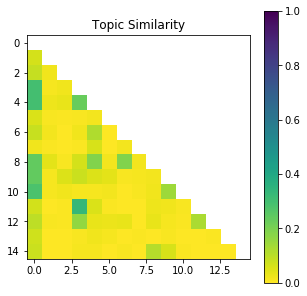

,Popularity,topWords,Year
0,0.14,"[reaction, temperature, rate, reactor, model, ...",All
1,0.07,"[co2, capture, co2 capture, gas, absorption, m...",All
2,0.07,"[adsorption, adsorbent, capacity, adsorption c...",All
3,0.11,"[process, model, proposed, optimization, desig...",All
4,0.09,"[liquid, data, model, phase, experimental, equ...",All
5,0.06,"[membrane, membranes, flux, separation, water,...",All
6,0.06,"[transfer, mass transfer, mass, liquid, gas, g...",All
7,0.04,"[ils, ionic, ionic liquids, liquids, il, ionic...",All
8,0.07,"[flow, bed, gas, reactor, liquid, fluidized, v...",All
9,0.07,"[spectroscopy, electron, microscopy, ray, elec...",All


In [11]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1,figsize=(5,5))
plt.set_cmap('viridis_r')
im = ax.imshow(similarity,vmin=0, vmax=1)
plt.title('Topic Similarity')
fig.colorbar(im, ax=ax)
plt.show()
                                             
# Popularity Ranking
P = np.sum(U, axis = 0)/np.sum(U) 
n_top_words = 10
dSup = top_words(nmf, tfidf_feature_names, n_top_words, P, 'All')
dSup

In [12]:
# WAll0 = np.vstack(WAll)
Year = 1996
P = []
for i in range(len(WAll)):
    W = WAll[i]
    UYear = U[i*8:(i+1)*8]
    LHS = np.matmul(W,UYear)
    Year = Year+1
    # Popularity Ranking
    P.append(np.sum(LHS, axis = 0)/np.sum(LHS))

avgP = np.ones([(2020-1996),1])*np.mean(P)
P=np.vstack(P)

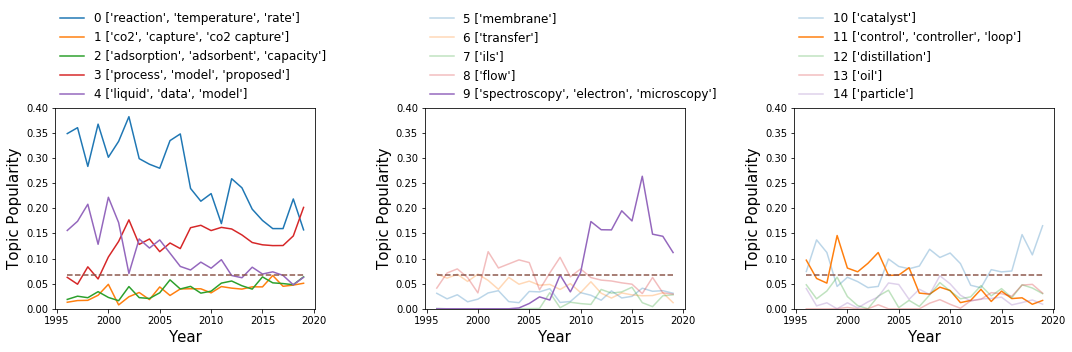

In [21]:
dSup.to_pickle("dSup.pkl")
np.save('PFile', P)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

dSup = pd.read_pickle("dSup.pkl")
P = np.load('PFile.npy') 

Years = range(1996,2020)
# order = [0,3,4,9,11,1,2,5,6,7,8,10,12,13,14]
fig, ax = plt.subplots(1,3,figsize=(15,5),tight_layout = True)
start = 0
for s in range(3):
    end = start + 5
    for i in range(start,end):
        if i==0 or i==1 or i==2 or i==3 or i==4 or i==9 or i==11:
            ax[s].plot(Years,P[:,i],'-',label=str(i)+' '+str(dSup.topWords[i][:3]))
        else:
            ax[s].plot(Years,P[:,i],'-',label=str(i)+' '+str(dSup.topWords[i][:1]),alpha = 0.3)
    ax[s].plot(Years,avgP,'--')
    ax[s].set_xlabel('Year', fontsize=15)
    ax[s].set_ylabel('Topic Popularity', fontsize=15)
    ax[s].set_ylim([0, 0.4])
    ax[s].legend(loc='lower left', bbox_to_anchor= (0.0, 1.01), ncol=1, 
            borderaxespad=0, frameon=False, fontsize=12)
    start = end
plt.show()

In [14]:
#Coherence Scores
def Coherence_score(xList):
    model = gensim.models.Word2Vec.load("word2vec.model")
    coh = 0 #np.zeros([len(xList),len(xList)])
    for i in range(1,len(xList)):
        for j in range(0,i-1):
             coh = coh + model.similarity(xList[i].split(' ', 1)[0], xList[j].split(' ', 1)[0]) 
    nCombs = len(xList)*(len(xList)-1)/2
    coh = coh/nCombs  
    return(coh)


xList1 = list(dtopWords[dtopWords['Year']==2018].topWords)[0]
coh = np.zeros(len(xList1))
for i in range(len(xList1)):
    coh[i] = Coherence_score(xList1[i])

print(coh)


[0.61888136 0.62487837 0.         0.66275144 0.63953187 0.
 0.         0.4469285  0.28889353 0.63655766]


In [15]:
# # Fit the NMF model
# print("Fitting the NMF model (generalized Kullback-Leibler divergence) with "
#       "tf-idf features, n_samples=%d and n_features=%d..."
#       % (n_samples, n_features))
# t0 = time()
# nmf = NMF(n_components=n_components, random_state=1,
#           beta_loss='kullback-leibler', solver='mu', max_iter=1000, alpha=.1,
#           l1_ratio=.5).fit(tfidf)
# print("done in %0.3fs." % (time() - t0))

# print("\nTopics in NMF model (generalized Kullback-Leibler divergence):")
# tfidf_feature_names = tfidf_vectorizer.get_feature_names()
# print_top_words(nmf, tfidf_feature_names, n_top_words)

# print("Fitting LDA models with tf features, "
#       "n_samples=%d and n_features=%d..."
#       % (n_samples, n_features))
# lda = LatentDirichletAllocation(n_components=n_components, max_iter=5,
#                                 learning_method='online',
#                                 learning_offset=50.,
#                                 random_state=0)
# t0 = time()
# lda.fit(tf)
# print("done in %0.3fs." % (time() - t0))

# print("\nTopics in LDA model:")
# tf_feature_names = tf_vectorizer.get_feature_names()
# print_top_words(lda, tf_feature_names, n_top_words)

In [16]:
from matplotlib.ticker import MaxNLocator
year1 = range(1999,2019)
Years = range(1996,2020)
totPapers = []
for i in Years:
    totPapers.append(len(df[df['Year'] == i]))
impactFactor = [1.39, 1.421, 1.423, 1.425, 1.42, 1.643, 1.787, 1.739, 1.907, 1.95, 1.894, 2.391, 2.665, 2.591, 2.633, 2.987, 2.898, 3.104, 3.349, 3.539]

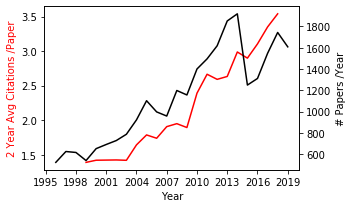

In [17]:
fig, ax = plt.subplots(1,1,figsize=(5,3),tight_layout=True)

color = tuple([x/255 for x in (255,0,0)]+[1])
ax.plot(year1,impactFactor,'-',color=color)
ax.set_xlabel('Year')
ax.set_ylabel('2 Year Avg Citations /Paper', color=color)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

color = tuple([x/255 for x in (0,0,0)]+[1])
ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(Years,totPapers,'-',color=color)
ax2.set_ylabel('# Papers /Year',color=color)
plt.show()

In [18]:
import seaborn as sns
dfPlot = df[df['Year']>1996]
dfPlot['#Authors'] = dfPlot['#Authors'].astype(float)

dfPlot.to_pickle("dIECR.pkl")
dfPlot = pd.read_pickle("dIECR.pkl")

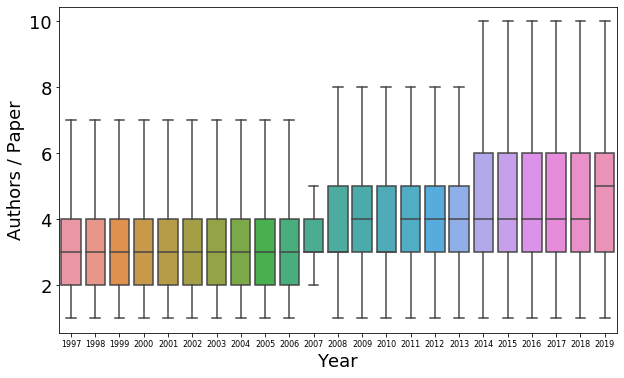

In [22]:
plt.figure(figsize=(10,6))
ax = sns.boxplot(x="Year", y="#Authors",
              data=dfPlot, showfliers=False)
plt.xlabel('Year', fontsize=18)
plt.ylabel('Authors / Paper', fontsize=18)
ax.tick_params(axis="x", labelsize=8)
ax.tick_params(axis="y", labelsize=18)
plt.show()